# Analyzing Cloudant related Stack Overflow Activity


* [Newest Cloudant questions on Stack Overflow](https://stackoverflow.com/search?tab=newest&q=cloudant)
* [Most popular Cloudant questions on Stack Overflow](https://stackoverflow.com/search?tab=votes&q=cloudant)


Import the required packages. (Install or update missing packages with `!pip install --user <package>`.)

In [29]:
import datetime
import pixiedust
import pyspark.sql.functions as func
import pyspark.sql.types as types

### Configure database connectivity

In [30]:
# @hidden_cell
# Read-only connection credentials for the Stack Overflow repository database
# TODO: replace **...** placeholders with your Cloudant repository connection credentials
host = '**host**'
username = '**username**'
password = '**password**'
database = 'questions'

### Load documents from the database

Load the documents into an Apache Spark DataFrame and describe the data structure.

In [ ]:
view = "_design/analysis/_view/question-documents?reduce=false&include_docs=true"

spark = SparkSession\
    .builder\
    .appName("Cloudant Spark SQL Example in Python using dataframes")\
    .config("cloudant.host",host)\
    .config("cloudant.username", username)\
    .config("cloudant.password", password)\
    .config("jsonstore.rdd.partitions", 1)\
    .getOrCreate()

# ***1. Loading dataframe from Cloudant db
so_data_df = spark.read.load(format="org.apache.bahir.cloudant", database=database, view=view, schemaSampleSize="-1")
so_data_df.cache() 
#print so_data_df.count()
#so_data_df.printSchema()

### Prepare the data

Select data that's relevant to this analysis.

In [32]:
key_tag = 'cloudant'
so_data_df = so_data_df.filter(func.array_contains("doc.question.tags",key_tag)) 

In [33]:
q_df = so_data_df.select(so_data_df.doc.question.question_id.alias("id"),
                         so_data_df.doc.question.title.alias("title"),
                         so_data_df.doc.question.tags.alias("tags"),                      
                         so_data_df.doc.question.is_answered.alias("answered"),
                         so_data_df.doc.question.answer_count.alias("answer_count"),  
                         so_data_df.doc.question.link.alias("link"),
                         so_data_df.doc.question.score.alias("score"),
                         so_data_df.doc.question.view_count.alias("views"),
                         so_data_df.doc.question.creation_date.alias("created"),
                         so_data_df.doc.question.owner.user_id.alias("originator"),
                         func.lit(1).alias("one")
                        )

def toUTCDatetime(created):
    """ 
    input: POSIX timestamp
    output: instance of datetime.datetime represeting the input
    """ 
    if created is not None:
        return datetime.datetime.utcfromtimestamp(created)
    return None
toUTCDatetimeUDF = func.udf(lambda c: toUTCDatetime(c), types.TimestampType())
q_df = q_df.withColumn("created", toUTCDatetimeUDF(q_df.created))

def getFormattedDateString(date_val, format_string):
    """ 
    input: datetime.datetime object
    input: date format string
    output: formatted date string
    """
    if date_val is not None:
        return date_val.strftime(format_string)
    return None
    
getFormattedDateStringUDF = func.udf(lambda d,f: getFormattedDateString(d,f), types.StringType())
q_df = q_df.withColumn("created_year", getFormattedDateStringUDF(q_df.created, func.lit("%Y")))
q_df = q_df.withColumn("created_month", getFormattedDateStringUDF(q_df.created, func.lit("%Y-%m")))
q_df = q_df.withColumn("created_day", getFormattedDateStringUDF(q_df.created, func.lit("%Y-%m-%d")))

# debug only
#q_df.printSchema()
#q_df.head(10)

## Question frequency
Identify how frequently questions about Cloudant were posted on StackOverflow:
* Choose `Options` > `Keys` > `created_day` to display daily totals
* Choose `Options` > `Keys` > `created_month` to display monthly totals (default)
* Choose `Options` > `Keys` > `created_year` to display yearly totals


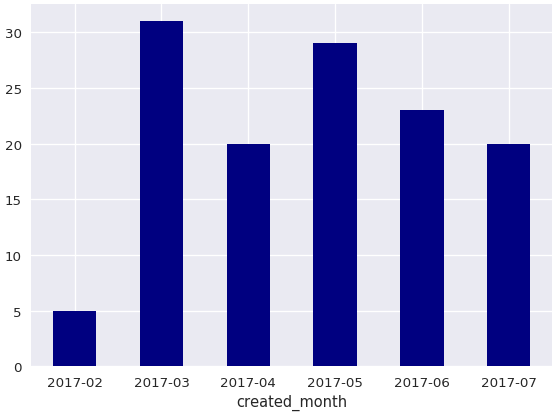

In [34]:
display(q_df.select(q_df.id, q_df.answered, q_df.tags, q_df.created_year, q_df.created_month,q_df.created_day))

## Tag frequency
Identify tags that were commonly associated with the 'Cloudant' tag


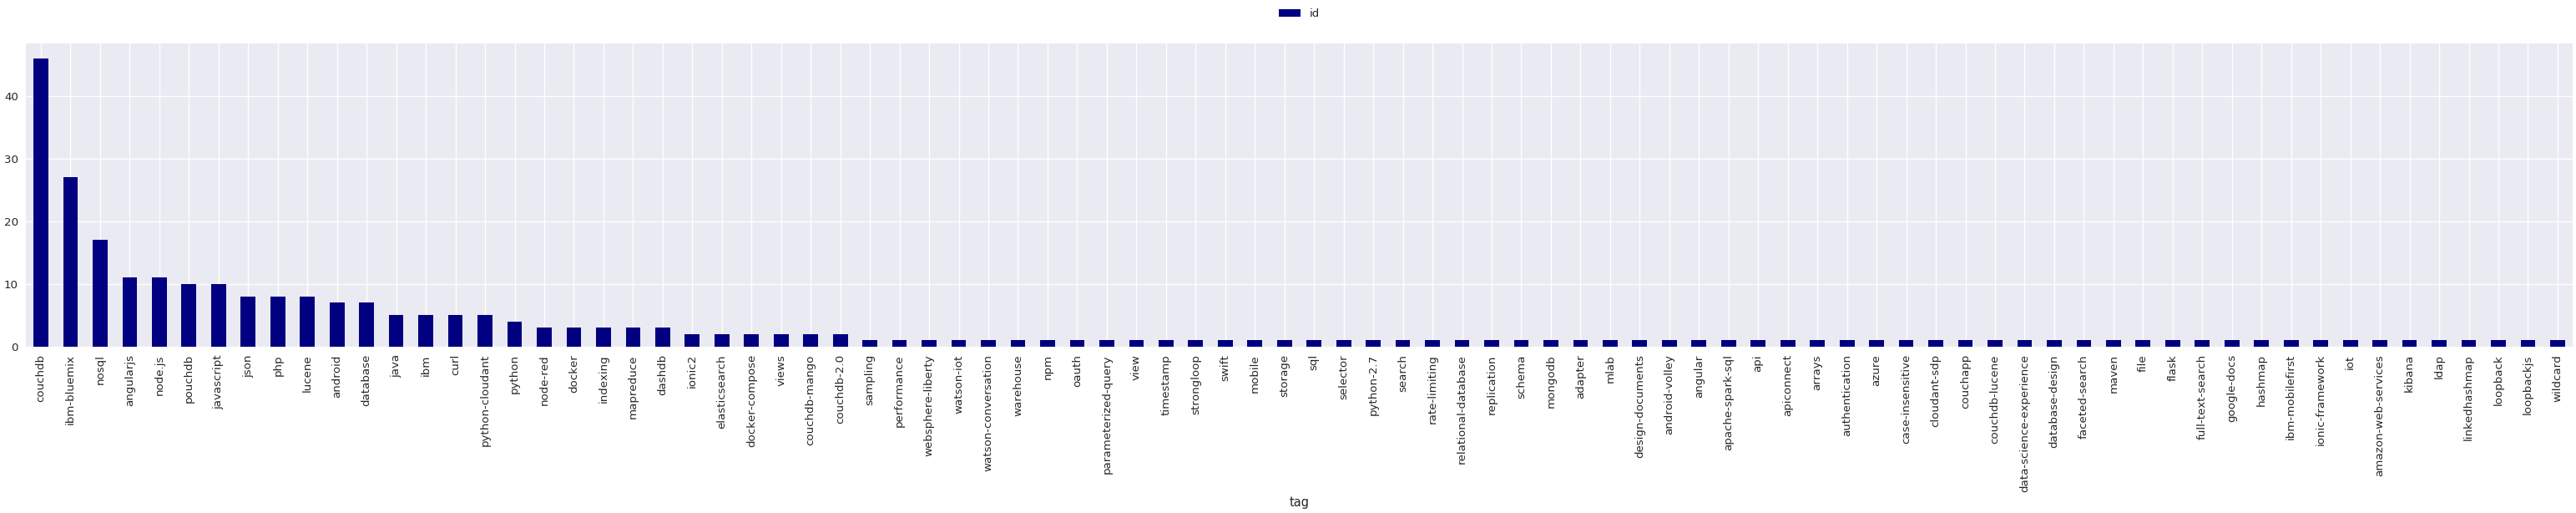

In [35]:
tags_df = q_df.select(q_df.id, q_df.answered, q_df.tags, q_df.created_year, q_df.created_month,q_df.created_day)
tags_df = tags_df.select(tags_df.id, func.explode(tags_df.tags).alias("tag"), tags_df.answered, q_df.created_year, q_df.created_month, q_df.created_day).filter("tag != '{}'".format(key_tag)).dropDuplicates(["id","tag"])
display(tags_df)

<hr>
## Associations with runtime environment or programming language
Questions sometimes contain tags that might identify a programming language or runtime environment, such as `node.js` or `ios`. 

In [36]:
# of the questions that meet the first condition only count those that also contain a tag that is associated with a programming language or runtime environment
# the following curated list was obtained from https://meta.stackoverflow.com/tags; customize as needed
env = ["node.js", "java", "javascript", "python", "android","php", "node-red", "cordova" ,"c#", "ios", "swift"]


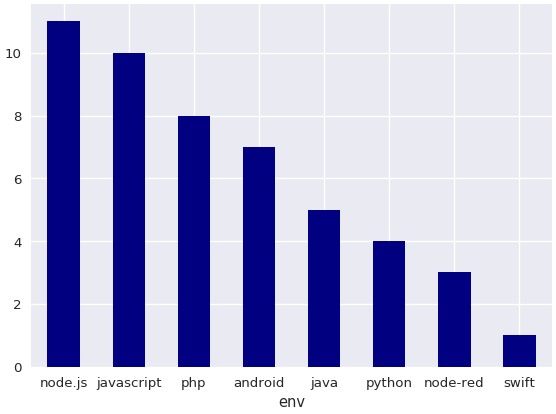

In [37]:
# ---------------
# prepare data
# ---------------
env_df = q_df.select(q_df.id, q_df.tags)
env_df = env_df.select(env_df.id, func.explode(env_df.tags).alias("tag"))
env_df = env_df.filter(func.col("tag").isin(env)).groupBy(["tag"]).count().orderBy("count", ascending = False).withColumnRenamed("tag","env")

display(env_df)

## Accepted answer status

The SO user who asked a question can accept one of the provided answers as the "correct" one. Note though that not every question has an accepted answer because
* none of the given answers was deemed to be correct or
* the user wasn't familiar with SO etiquette and therefore did not accept an answer even though it was correct (some users just comment on an answer saying "Thanks, that works!"

### Accepted answer status by tag


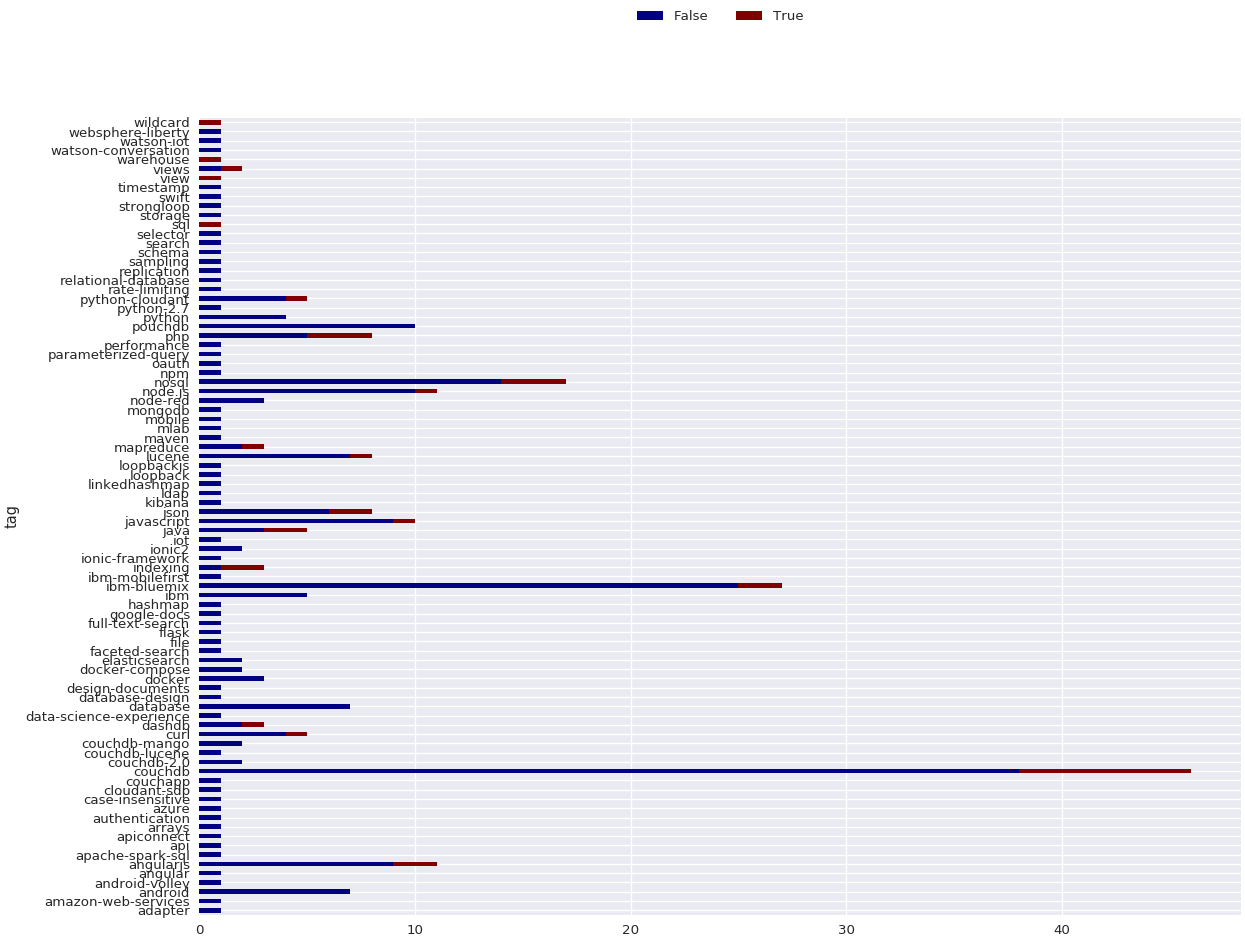

In [38]:
# answer status by tag, e.g. "tag" answered: 25 not answered: 12
display(tags_df.dropDuplicates(["id","tag"]))

### Accepted answer status by date

* Choose `Options` > `Keys` > `created_day` to display answer status by day
* Choose `Options` > `Keys` > `created_month` to display answer status by month (default)
* Choose `Options` > `Keys` > `created_year` to display answer status by year


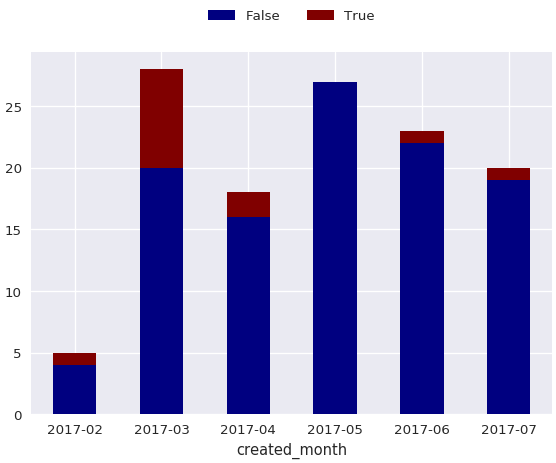

In [39]:
# answer status by date, e.g. "July 2017" answered: 20 not answered: 10
display(tags_df.dropDuplicates(["id"]))

## Demographics
### Who is asking questions about Cloudant


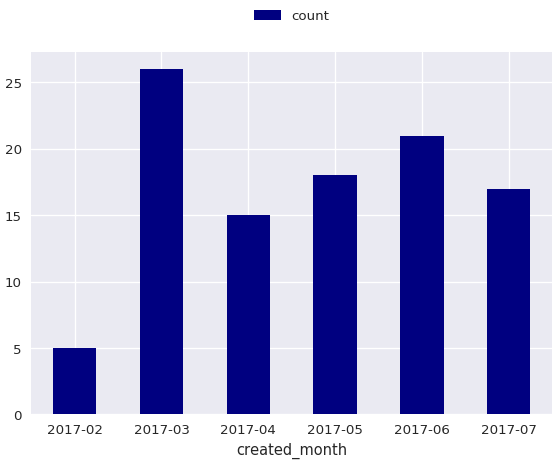

In [40]:
display(q_df.dropDuplicates(["created_month", "originator"]).groupBy("created_month").count())